# Computational Geometry



## Overview

Computational geometry is divided into two main branches:

1. *Combinatorial computational geometry*, which considers problems stated in terms of basic geometrical objects: points, line segments, polygons, polyhedra, etc. Examples of problems in this field include:

  - *Line segment intersection*: Find the intersections between a given set of line segments.
  - *Convex hull*: Given a set of points, find the smallest convex polyhedron/polygon containing all the points.
  - *Polygon triangulation*: Given a polygon, partition its interior into triangles
  - *Point in polygon*: Decide whether a point is inside or outside a given polygon.
  - *Mesh generation*: Generate a polygonal mesh that approximates a geometric domain
  
  
2. *Numerical computational geometry*, closely related to *Computer-aided design (CAD)*, considers problems involving curves and surfaces, represented e.g. in Bézier or spline form. These are extensively used in various engineering disciplines, and important problems include the efficient representation of general shapes, and operations such as intersection of surfaces and other objects.

### Point representation

The first geometric entity to consider is a point. Here we will consider planar problems, so a point can be represented by its $(x,y)$ coordinates, as two `Float64` numbers in Julia. Here we will simply use a vector with 2 elements.

To store a *collection of points*, we could store the $(x,y)$ coordinates as the columns or the rows of a 2D array. However, we will instead use an *array of arrays*, that is, a 1D array of all the points as 1D arrays $(x,y)$. This simplifies some of the algorithms.

In [1]:
p = [ randn(2) for i = 1:10 ] # 10 random points - note array-of-array

10-element Vector{Vector{Float64}}:
 [2.1728796984648726, 0.23092750528602504]
 [-0.5296053234454603, -0.28563715248691]
 [-1.4121030020377365, 0.14401744494410312]
 [-0.24788541440356532, -0.8954657521107267]
 [1.4779723500693054, 1.8715153568828573]
 [-0.3309631900018019, -0.5335666430181089]
 [0.16961846700397193, -2.414759783660738]
 [0.5838878481090782, 0.1717445440842808]
 [-1.2147325668973972, -0.1510960780531411]
 [-0.5686815602974045, -0.5408163489377474]

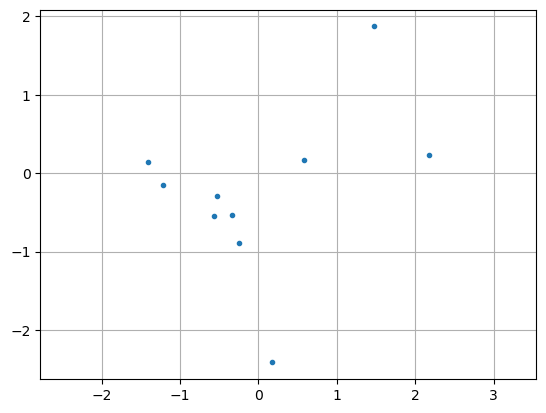

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/mfranco/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [2]:
# Plot the points as dots
# The functions first and last simply collects the corresponding indices
using PyPlot
plot(first.(p), last.(p), ".")
axis("equal"); grid(true);

## Convex hull

The *convex hull* of a set $X$ of points is the smallest convex set that contains $X$. In the plane, this is a polygon through a subset of the points. Many algorithms have been proposed for computing the convex hull, and here we will focus on the *Jarvis march* algorithm, also called the *gift wrapping algorithm*.

The method is illustrated below. The main steps are as follows:

1. Find the leftmost point $p_0$ (smallest $x$-coordinate)
2. Find the next point $p_1$ such that all other points are to the right of the line $p_0p_1$
3. Repeat until $p_n=p_0$

![Jarvis_march_convex_hull](jarvis_march_convex_hull.png "Convex Hull")
(from <https://en.wikipedia.org/wiki/Gift_wrapping_algorithm>)

The main utility function needed in the algorithm is to decide if a point $p_2$ is to the right of the line $p_1p_3$. We do this by computing the $z$-coordinate of the cross product of the vectors $p_2-p_1$ and $p_3-p_1$, which is $>0$ if the line $p_1p_2$ is clockwise oriented to the line $p_1p_3$. *Note*: If the lines are parallel this cross product is zero, which is a special case that we for simplicity do not handle here.

In [3]:
function clockwise_oriented(p1, p2, p3)
    # Return true if the line-segment between points p1,p2 is clockwise
    # oriented to the line-segment between points p1,p3
    cross = (p3[2] - p1[2]) * (p2[1] - p1[1]) - (p3[1] - p1[1]) * (p2[2] - p1[2])
    return cross > 0
end

clockwise_oriented (generic function with 1 method)

In [4]:
# Tests
println(clockwise_oriented([0,0], [1,1], [2,3]))
println(clockwise_oriented([0,0], [1,1], [3,2]))

true
false


The method can now be implemented as follows. Note the two loops:

1. The outer loop considers each point $p_0,p_1,\ldots$ on the convex hull. This is a `while` loop, since we do not know beforehand how many points it will include.
2. The inner loop finds the next point such that all other points are to the right of the corresponding line segment. This is done by computing orientations to all other points.

From this, it is clear that the computational complexity of the algorithm is $\mathcal{O}(nh)$, where $n$ is the number of points and $h$ is the number of points on the complex hull.

In [5]:
function convex_hull(p)
    # Find the nodes on the convex hull of the point array p using
    # the Jarvis march (gift wrapping) algorithm

    _, pointOnHull = findmin(first.(p)) # Start at left-most point
    hull = [pointOnHull] # Output: Vector of node indices on the convex hull
    
    while length(hull) ≤ 1 || hull[1] != hull[end] # Loop until closed polygon
        nextPoint = hull[end] % length(p) + 1 # First candidate, any point except current
        for j = 1:length(p) # Consider all other points
            if clockwise_oriented(p[hull[end]], p[nextPoint], p[j]) # If "more to the left", switch
                nextPoint = j
            end
        end
        push!(hull, nextPoint) # Update current point
    end
    return hull
end

convex_hull (generic function with 1 method)

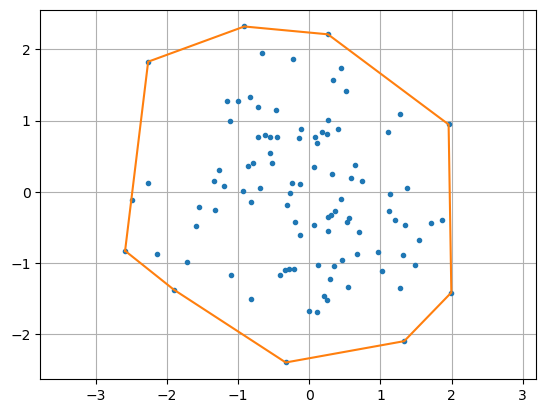

In [6]:
# Example: 100 random points, compute and draw the convex hull
p = [ randn(2) for i = 1:100 ]
hull = convex_hull(p)
plot(first.(p), last.(p), ".")
plot(first.(p[hull]), last.(p[hull]))
axis("equal"); grid(true);

### Line-segment intersections

A *line-segment* can be described by its two endpoints, $p_1$ and $p_2$, and denoted by $p_1p_2$. Note that the set of points on this segments can be expressed as $p_1 + s(p_2-p_1)$ for a parameter value $s\in[0,1]$.

To determine if $p_1p_2$ intersects another line-segment $q_1q_2$, we express the points on both segments in this way (with different parameters $s,t$), and set the points equal. This leads to the problem: Find $s,t\in[0,1]$ s.t.

$$
p_1 + s(p_2 - p_1) = q_1 + t(q_2 - q_1)
$$

which can be reorganized as a 2-by-2 linear system of equations for $s,t$:

$$
\begin{pmatrix}
p_2 - p_1 & q_1 - q_2
\end{pmatrix}
\begin{pmatrix}
s \\ t
\end{pmatrix} =
\begin{pmatrix}
q_1 - p_1
\end{pmatrix}
$$

If the line-segments are parallel, the matrix is singular. For simplicity we simply say that they do not intersect in this case, but a better implementation would determine if they actually overlap.

We implement the method in the function below, where we have also included a tolerance $\delta$. This is useful to handle the case when the intersection is close to one of the endpoints, then $\delta>0$ would allow for a small positive overlap and $\delta<0$ a small negative overlap.

In [7]:
using LinearAlgebra
function linesegment_intersect(p1, p2, q1, q2, δ)
    A = [p2-p1 q1-q2]
    b = q1-p1
    if rank(A) == 2
        st = A \ b
        if all(-δ .≤ st .≤ 1 + δ)
            pintersect = p1 + st[1] * (p2 - p1)
            return true, pintersect
        else
            return false, nothing
        end
    else
        # Warning: parallel lines, should check if they actually overlap
        return false, nothing
    end
end

linesegment_intersect (generic function with 1 method)

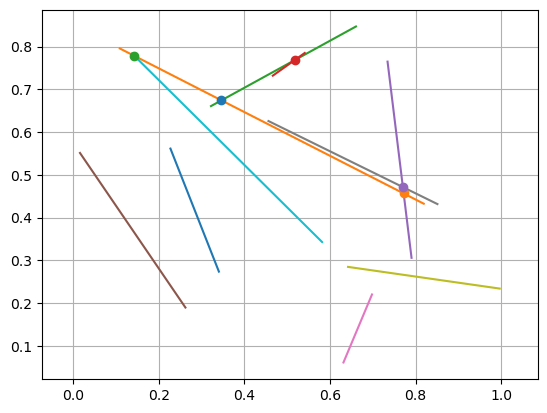

In [8]:
# Example: n random lines, find and plot all intersections
n = 10
lines = [ [rand(2), rand(2)] for i = 1:n ]

# Plot all lines
for line in lines
    plot([line[1][1], line[2][1]], [line[1][2], line[2][2]])
end

# Find all intersections - note that we only consider j>i to avoid checking
# the same 2 line-segments twice
for i = 1:n
    for j = i+1:n
        isect, pq = linesegment_intersect(lines[i][1], lines[i][2], lines[j][1], lines[j][2], 0)
        if isect
            plot(pq[1], pq[2], "o")
        end
    end
end

axis("equal"); grid(true);

### Triangulations

A triangulation of a polygon is a subdivision into triangles. This has numerous applications, for example in computer graphics, visualization, numerical solution of PDEs, and interpolation.

First let us define a function to plot a triangulation. The function below is based on PyPlot, and it takes an array of points `p` and an array of triangle indices `t`.

In [9]:
function tplot(p, t)
    # Plot triangular mesh with nodes `p` and triangles `t`
    tris = convert(Array{Int64}, hcat(t...)')
    tripcolor(first.(p), last.(p), tris .- 1, 0*tris[:,1],
              cmap="Set3", edgecolors="k", linewidth=1)
    axis("equal")
    return
end

tplot (generic function with 1 method)

We can test the function using a simple set of points and a triangulation:

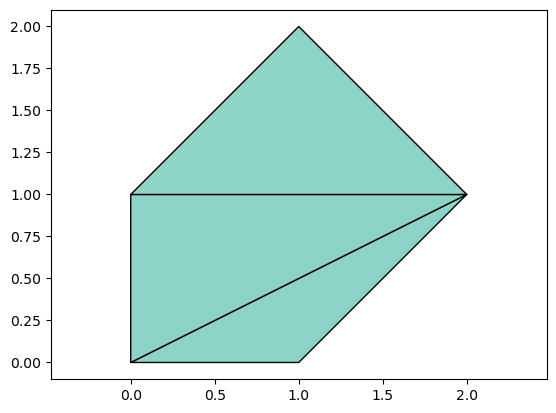

In [10]:
p = [[0,0], [1,0], [0,1], [1,2], [2,1]]
t = [[1,2,5], [1,5,3], [3,5,4]]
tplot(p,t)

#### Delaunay triangulation

A *Delaunay triangulation* for a given set of discrete points in a plane is a triangulation such that no point is inside the circumcircle of any triangle. It can be shown that Delaunay triangulations maximize the minimum angle of all the angles of the triangles in the triangulation, which makes them very useful e.g. in finite element methods for numerical solution of PDEs.

Many algorithms have been developed for computing a Delaunay triangulation from a set of points, and here we will simply use an existing implementation in the `Triangle` package:

In [14]:
using Triangle

function delaunay(p)
    # Delaunay triangulation `t` of array of nodes `p`
    vertex_map = Array{Int64,1}(1:size(p,1))
    t = Triangle.basic_triangulation(convert(Array{Float64}, hcat(p...)'), vertex_map)
end

delaunay (generic function with 1 method)

First, let us compute and plot the Deluanay triangulation of the same points as before:

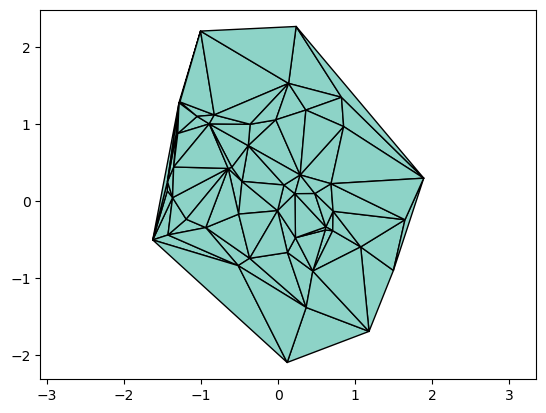

In [15]:
t = delaunay(p)
tplot(p,t)

Note that this triangulation is different than our previous one - it satisfies the properties mentioned above.

Next let us compute and plot the delaunay triangulation of a random set of points:

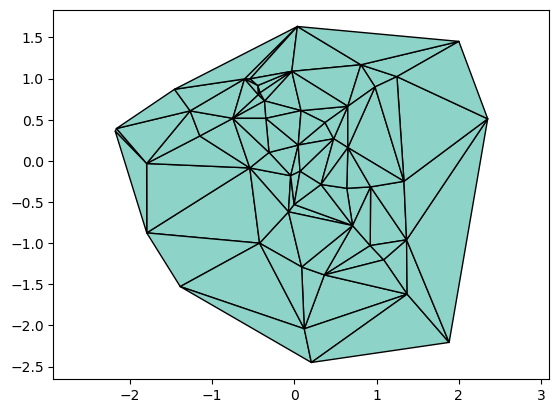

In [16]:
p = [ randn(2) for i = 1:50 ]
t = delaunay(p)
tplot(p,t)